# **Named Entity recognition with spaCy**
---
    Course - B9DA109: Machine Learning and Pattern Recognition
---
    Group No.3:
    20066423 - Anish Rao
    20054683 - Adithya Durgapu
    20058721 - Phani Sri Pavansai Sharath Chandra Chavali Venkata
---
### Dataset - [BioCreative-V CDR Corpus](https://github.com/JHnlp/BioCreative-V-CDR-Corpus)
---

## **Project Goal & Approach**



**Goal**:
> Develop an NER system capable of identifying entities in biomedical texts using active learning and rule-based techniques.

**Approach**:
> - Build a custom NLP pipeline using spaCy
- Use spaCy’s rule-based matching to create weak labels for training
- Apply active learning to prioritize uncertain samples for labeling
- Evaluate using precision/recall/F1 on test set

# **Imports**

In [1]:
!pip install -U spacy

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter

import spacy
from spacy.matcher import Matcher #more flexible than EntityRuler
from spacy.scorer import Scorer
from spacy.training import Example
import spacy.util

import warnings

# load blank spacy model
nlp = spacy.blank("en")

# **Data Loading & Parsing**

## Loading

In [3]:
train_path = "CDR_TrainingSet.PubTator.txt"
dev_path = "CDR_DevelopmentSet.PubTator.txt"
test_path = "CDR_TestSet.PubTator.txt"

def load_data(path):
  """
  Reads and loads data from given file path.

  Args:
      path: The file path of the dataset.

  Returns:
      list: A list containing each line of the file as a string.
  """
  with open(path, 'r', encoding='utf-8') as file:
      data = file.readlines()
  return data

train_data = load_data(train_path)
dev_data = load_data(dev_path)
test_data = load_data(test_path)

print("\nSample Train Data:\n", train_data[:10])


Sample Train Data:
 ['227508|t|Naloxone reverses the antihypertensive effect of clonidine.\n', '227508|a|In unanesthetized, spontaneously hypertensive rats the decrease in blood pressure and heart rate produced by intravenous clonidine, 5 to 20 micrograms/kg, was inhibited or reversed by nalozone, 0.2 to 2 mg/kg. The hypotensive effect of 100 mg/kg alpha-methyldopa was also partially reversed by naloxone. Naloxone alone did not affect either blood pressure or heart rate. In brain membranes from spontaneously hypertensive rats clonidine, 10(-8) to 10(-5) M, did not influence stereoselective binding of [3H]-naloxone (8 nM), and naloxone, 10(-8) to 10(-4) M, did not influence clonidine-suppressible binding of [3H]-dihydroergocryptine (1 nM). These findings indicate that in spontaneously hypertensive rats the effects of central alpha-adrenoceptor stimulation involve activation of opiate receptors. As naloxone and clonidine do not appear to interact with the same receptor site, the observe

## Parsing

In [4]:
def parse_data(data):
  """
  Parses PubTator formatted dataset to extract text and entity annotations.

  Args:
      data: List of lines from the dataset.

  Returns:
      list: A list of tuples where each tuple contains:
            - "text": The combined document text (title + abstract).
            - "entities": A list of entity annotations as tuples
                          (start, end, entity_type/label).
  """
  with open(data, 'r', encoding='utf-8') as f:
      text = f.read()

  docs = []
  current = {"text": "", "entities": []}

  for line in text.split("\n"):
      if line.startswith("#####"):
          continue
      if "|t|" in line:
          current["text"] = line.split("|t|")[-1].strip()
      elif "|a|" in line:
          current["text"] += " " + line.split("|a|")[-1].strip()
      elif "\t" in line:
          parts = line.split("\t")
          if len(parts) >= 5:
              start, end, label = int(parts[1]), int(parts[2]), parts[4]
              current["entities"].append((start, end, label))
      elif line.strip() == "" and current["text"]:
          docs.append(current)
          current = {"text": "", "entities": []}

  return docs #("Document text", [(start1, end1, type1), (start2, end2, type2)])

train = parse_data(train_path)
dev = parse_data(dev_path)
test = parse_data(test_path)

train_dev = train + dev

### Viewing parsed documents

In [5]:
# Display sample parsed documents
print("\nSample Parsed Documents:")
for i, doc in enumerate(train_dev[:1]):
    print(f"\nDocument {i+1}:")
    print("Text:", doc["text"][:200] + "...")
    print("Entities:")
    for start, end, label in doc["entities"]:
        entity_text = doc["text"][start:end]
        print(f"  - {label}: '{entity_text}' (Position: {start}-{end})")


Sample Parsed Documents:

Document 1:
Text: Naloxone reverses the antihypertensive effect of clonidine. In unanesthetized, spontaneously hypertensive rats the decrease in blood pressure and heart rate produced by intravenous clonidine, 5 to 20 ...
Entities:
  - Chemical: 'Naloxone' (Position: 0-8)
  - Chemical: 'clonidine' (Position: 49-58)
  - Disease: 'hypertensive' (Position: 93-105)
  - Chemical: 'clonidine' (Position: 181-190)
  - Chemical: 'nalozone' (Position: 244-252)
  - Disease: 'hypotensive' (Position: 274-285)
  - Chemical: 'alpha-methyldopa' (Position: 306-322)
  - Chemical: 'naloxone' (Position: 354-362)
  - Chemical: 'Naloxone' (Position: 364-372)
  - Disease: 'hypertensive' (Position: 469-481)
  - Chemical: 'clonidine' (Position: 487-496)
  - Chemical: '[3H]-naloxone' (Position: 563-576)
  - Chemical: 'naloxone' (Position: 589-597)
  - Chemical: 'clonidine' (Position: 637-646)
  - Chemical: '[3H]-dihydroergocryptine' (Position: 671-695)
  - Disease: 'hypertensive' (Pos

# **Exploratory Data Analysis (EDA)**

Total number of documents: 1000
Average document length (characters): 1299.7
Unique Entity Labels and Their Counts:
Chemical: 10550
Disease: 8426
Average number of entities per document: 18.98


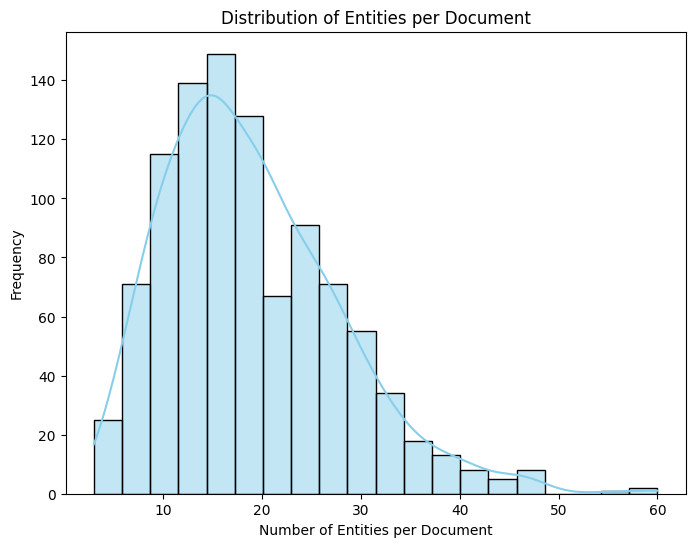

<ipython-input-6-a7b675584ac6>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


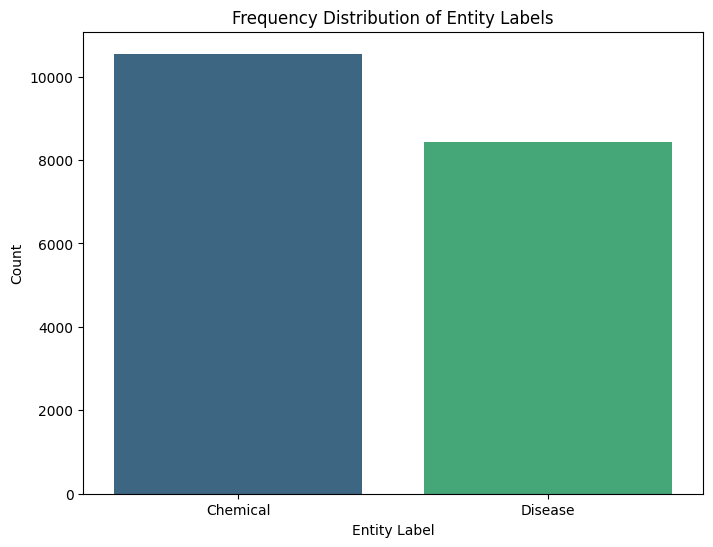

In [6]:
num_docs = len(train_dev)
print("Total number of documents:", num_docs)

# Number of characters per document
doc_lengths = [len(doc["text"]) for doc in train_dev]
avg_length = sum(doc_lengths) / num_docs
print("Average document length (characters):", round(avg_length, 2))

# unique labels and their counts
label_counter = Counter(entity[2] for doc in train_dev for entity in doc["entities"])
print("Unique Entity Labels and Their Counts:")
for label, count in label_counter.items():
    print(f"{label}: {count}")

# Number of entities per document
num_entities = [len(doc["entities"]) for doc in train_dev]
avg_entities = sum(num_entities) / num_docs
print("Average number of entities per document:", round(avg_entities, 2))

# Histogram for the distribution of entities per document
plt.figure(figsize=(8, 6))
sns.histplot(num_entities, bins=20, kde=True, color="skyblue")
plt.xlabel("Number of Entities per Document")
plt.ylabel("Frequency")
plt.title("Distribution of Entities per Document")
plt.show()

# Frequency distribution of entity labels
label_counts = {}
for doc in train_dev:
    for ent in doc["entities"]:
        label = ent[2]
        label_counts[label] = label_counts.get(label, 0) + 1

# Bar chart for entity label frequencies
labels = list(label_counts.keys())
counts = list(label_counts.values())
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=counts, palette="viridis")
plt.xlabel("Entity Label")
plt.ylabel("Count")
plt.title("Frequency Distribution of Entity Labels")
plt.show()

# **Defining Rule-Based Matcher**

In [7]:
matcher = Matcher(nlp.vocab)

chem_patterns = [
    [{"TEXT": {"REGEX": ".*ol$"}}],
    [{"TEXT": {"REGEX": ".*ine$"}}],
    [{"TEXT": {"REGEX": ".*ide$"}}],
    [{"TEXT": {"REGEX": ".*ium$"}}],
    [{"TEXT": {"REGEX": ".*one$"}}],
    [{"TEXT": {"REGEX": ".*amine$"}}],
    [{"TEXT": {"REGEX": ".*ate$"}}],
    [{"TEXT": {"REGEX": ".*rin$"}}],
    [{"LOWER": {"IN": ["acid", "salt"]}}],
    [{"TEXT": {"REGEX": ".*azole$"}}],
    [{"TEXT": {"REGEX": ".*vir$"}}],
    [{"TEXT": {"REGEX": ".*dopa$"}}],
    # [{"TEXT": {"REGEX": ".*mab$"}}]
]

disease_patterns = [
    [{"TEXT": {"REGEX": ".*itis$"}}],
    [{"TEXT": {"REGEX": ".*osis$"}}],
    [{"TEXT": {"REGEX": ".*emia$"}}],
    [{"TEXT": {"REGEX": ".*opathy$"}}],
    # [{"TEXT": {"REGEX": "^cardiac$"}}, {"TEXT": {"REGEX": "^asystole$"}}],
    [{"TEXT": {"REGEX": "^heart$"}}, {"TEXT": {"REGEX": "^attack$"}}],
    [{"TEXT": {"REGEX": "^myocardial$"}}, {"TEXT": {"REGEX": "^infarction$"}}],
    [{"TEXT": {"REGEX": "^(AD|MS|ALS|HIV|AIDS|COVID)$"}}],
    # [{"TEXT": {"REGEX": "^diabetes$"}}],
    [{"LOWER": {"IN": ["disease", "syndrome", "cancer"]}}],
    [{"LOWER": {"IN": ["infection", "fever", "headache",
                       "tumor", "inflammation"]}}],
]

matcher.add("CHEMICAL", chem_patterns)
matcher.add("DISEASE", disease_patterns)


def apply_rules(text):
  """
  Applies the matcher to a text and sets the detected entities.

  Args:
      text: The input text to annotate.

  Returns:
      spacy.tokens.Doc: The processed doc with entities set.
  """
  doc = nlp(text)
  matches = matcher(doc)
  spans = []
  for match_id, start, end in matches:
      label = nlp.vocab.strings[match_id]
      span = spacy.tokens.Span(doc, start, end, label=label)
      spans.append(span)
  doc.ents = spans
  return doc

In [8]:
test_text = "The patient was administered naloxone and clonidine for cardiac asystole and diabetes. Ethanol is used to treat arthritis and leukemia. Swimming pools"
doc = apply_rules(test_text)

matches = matcher(doc)
print("\nMatcher Results:")
for match_id, start, end in matches:
    print(f"{doc[start:end].text} - {nlp.vocab.strings[match_id]}")


Matcher Results:
naloxone - CHEMICAL
clonidine - CHEMICAL
Ethanol - CHEMICAL
arthritis - DISEASE
leukemia - DISEASE


# **Model Training Method**

In [9]:
def train_ner_model(model, data, n_iter=10):
  """
  Trains a custom Named Entity Recognition (NER) model using spaCy.

  Args:
      model: The spaCy NLP model.
      data: list of training examples as dictionary with "text" and "entities".
      n_iter: Number of training iterations (epochs).

  Returns:
      None
  """
  # Add the NER component if it does not exist in the model
  if "ner" not in model.pipe_names:
      ner = model.add_pipe("ner", last=True)
  else:
      ner = model.get_pipe("ner")

  # Add entity labels to the NER component from the data
  for doc_data in data:
      for ent in doc_data["entities"]:
          label = ent["label"] if isinstance(ent, dict) else ent[2]
          try:
              ner.add_label(label)
          except Exception as e:
              pass

  # Prepare training examples in spaCy's required format
  training_examples = []
  for doc_data in data:
      text = doc_data["text"]
      ents = []
      for ent in doc_data["entities"]:
          if isinstance(ent, dict):
              ents.append((ent["start"], ent["end"], ent["label"]))
          else:
              ents.append(ent)
      annotations = {"entities": ents}
      training_examples.append(Example.from_dict(model.make_doc(text), annotations))

  optimizer = model.begin_training()
  for i in range(n_iter):
      random.shuffle(training_examples)
      losses = {}
      batches = spacy.util.minibatch(training_examples, size=4)
      for batch in batches:
          model.update(batch, drop=0.3, sgd=optimizer, losses=losses)
      print(f"Iteration {i+1}, Loss: {losses.get('ner', 0):.4f}")

  print("\nModel Training Completed!")

# **Uncertainty Sampling & Active Learning**

In [10]:
def uncertainty_sampling(model, data, n_samples=5):
  """
  Uncertainty sampling by scoring documents based on the
  inverse number of entities detected.

  Args:
      model: The trained spaCy model.
      data: List of document dictionaries with "text" and "entities".
      n_samples: Number of samples to select based on uncertainty.

  Returns:
      list: A list of selected text samples with the highest uncertainty.
  """
  scored_samples = []
  for doc_data in data:
      text = doc_data["text"]
      doc = model(text)
      if len(doc.ents) == 0:
          uncertainty_score = 1.0
      else:
          uncertainty_score = 1.0 / len(doc.ents)
      scored_samples.append((text, uncertainty_score))

  # Sort documents by uncertainty score in descending order
  scored_samples.sort(key=lambda x: x[1], reverse=True)
  return [sample[0] for sample in scored_samples[:n_samples]]



def manual_annotation(text):
  """
  Applying the matcher to the text.

  Args:
      text: The input text to annotate.

  Returns:
      list: A list of dictionaries with keys
            "start", "end", and "label" for each detected entity.
  """
  doc = apply_rules(text)
  return [{"start": ent.start_char, "end": ent.end_char, "label": ent.label_}
          for ent in doc.ents]

def active_learning_loop(model, data, iterations=3, n_samples=5):
  """
  Runs an active learning loop to iteratively improve the model.

  Args:
      model: The spaCy NLP model.
      data: The training data (list of document dictionaries).
      iterations: Number of active learning iterations.
      n_samples: Number of uncertain samples to select in each iteration.

  Returns:
      None: The function updates the model and data in place.
  """
  for i in range(iterations):
    print(f"\nActive Learning Iteration {i+1}/{iterations}")
    # If not the first iteration, load the model from the previous iteration
    if i > 0:
        model = spacy.load(f"model_iteration_{i}")

    # Select uncertain samples from the data based on uncertainty sampling
    selected_texts = uncertainty_sampling(model, data, n_samples)
    print("Selected uncertain samples for annotation:")
    for text in selected_texts:
        print("  -", text[:150] + "...")

    # Annotate the selected samples using manual_annotation
    new_annotations = []
    for text in selected_texts:
        annotated_entities = manual_annotation(text)
        new_annotations.append({"text": text, "entities": annotated_entities})

    # Update the training data with these new annotations
    data.extend(new_annotations)
    print("New annotations added.")

    # Retrain the model with the updated data
    train_ner_model(model, data, n_iter=10)
    model_path = f"model_iteration_{i+1}"
    model.to_disk(model_path)

  print("\nActive Learning Loop Completed!")

## Execution

In [11]:
warnings.filterwarnings('ignore')

In [12]:
nlp.initialize()
active_learning_loop(nlp, train_dev, iterations=3, n_samples=5)


Active Learning Iteration 1/3
Selected uncertain samples for annotation:
  - Naloxone reverses the antihypertensive effect of clonidine. In unanesthetized, spontaneously hypertensive rats the decrease in blood pressure and hear...
  - Lidocaine-induced cardiac asystole. Intravenous administration of a single 50-mg bolus of lidocaine in a 67-year-old man resulted in profound depressi...
  - Suxamethonium infusion rate and observed fasciculations. A dose-response study. Suxamethonium chloride (Sch) was administered i.v. to 36 adult males a...
  - Galanthamine hydrobromide, a longer acting anticholinesterase drug, in the treatment of the central effects of scopolamine (Hyoscine). Galanthamine hy...
  - Effects of uninephrectomy and high protein feeding on lithium-induced chronic renal failure in rats. Rats with lithium-induced nephropathy were subjec...
New annotations added.
Iteration 1, Loss: 31886.8305
Iteration 2, Loss: 13604.3172
Iteration 3, Loss: 10283.5952
Iteration 4, Loss: 8439

# **Evaluation Metrics**

In [13]:
def evaluate_model(model, test_data):
  """
  Evaluates the trained NER model on the test data.

  Args:
      model: The trained spaCy model.
      test_data: The test data, a list of document dictionaries.

  Returns:
      tuple: A tuple containing precision, recall, and F1-score.
  """
  y_true, y_pred = [], []

  for doc_data in test_data:
      text = doc_data["text"]
      # Create a set of gold standard entities from the test data
      gold_entities = {(start, end, label) for start, end, label
                       in doc_data["entities"]}

      doc = model(text)
      # Create a set of entities predicted by the model
      predicted_entities = {(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents}

      # Track all possible labels
      all_labels = set([ent[2] for ent in gold_entities]).union(set([ent[2] for ent in predicted_entities]))

      # For each label, calculate true positives, false positives, and false negatives
      for label in all_labels:
          tp = len([e for e in gold_entities if e in predicted_entities and e[2] == label])
          fp = len([e for e in predicted_entities if e not in gold_entities and e[2] == label])
          fn = len([e for e in gold_entities if e not in predicted_entities and e[2] == label])

          y_true.extend([label]*tp) # True positives: correct predictions
          y_pred.extend([label]*tp)

          y_true.extend([label]*fn) # False negatives: missing predictions
          y_pred.extend(["O"]*fn)

          y_true.extend(["O"]*fp) # False positives: extra predictions
          y_pred.extend([label]*fp)

  # Use micro average for entity-level metrics
  precision, recall, f1, _ = precision_recall_fscore_support(
      y_true, y_pred, average="micro", labels=list(set(y_true) - {"O"})
      )
  print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
  return precision, recall, f1

# Execution

In [14]:
evaluate_model(nlp, test)

Precision: 0.8484, Recall: 0.8049, F1-Score: 0.8261


(0.8483773909305824, 0.8048730757467631, 0.8260528380852733)

# **Conclusion:**
**Precision: 0.8484**

When the model predicts an entity, there is about an 85% chance that the prediction is correct.

---
**Recall: 0.8049**

The model successfully identifies about 80% of the actual entities present in the text.

Roughly 20% of the true entities are being missed.

---
**F1-Score: 0.8261**

The F1-score is around 83%, reflecting a strong balance between prediction accuracy (precision) and entity capture (recall).
